In [595]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [701]:
data_downsampled = np.genfromtxt('data_clinton_downsampled.csv', delimiter=',')

In [702]:
data_downsampled.shape

(1587, 3)

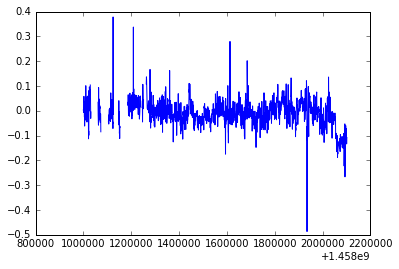

In [703]:
plt.plot(data_downsampled[:,0], data_downsampled[:,1])

In [704]:
%%capture
data = np.genfromtxt('data_clinton_00000.csv', delimiter=',', usecols=(0,1,2), invalid_raise=False, loose=True);

In [705]:
data.shape

(1075374, 3)

In [706]:
data[0]

array([  1.45945647e+09,   0.00000000e+00,   7.15635986e+17])

In [707]:
# data = np.array([d for d in data if not d[1] == 0])
# print data.shape                 

# Mode

In [708]:
from scipy.stats import mode

In [709]:
modes = []
tweetids = []
tweets = 0
min_tweets = 100
prev_time = data[0,0]
R = 10*60

for row in data:
    tweets += 1
    if not row[1] == 0:
        tweetids.append(row[2])
    time_diff = float(row[0]) - prev_time
    if time_diff > R:
#         if int(time_diff / R) > 1:
#             modes.append([row[0]-(time_diff*0.5), None, None, None])
        if time_diff > R and tweets > min_tweets:
            m = mode(tweetids)
            modes.append([row[0]-(R*0.5), m[0][0], m[1][0], m[1][0]/len(tweetids), len(tweetids)])
        tweetids = []
        prev_time = float(row[0])
        tweets = 0

In [710]:
np.array(modes).shape

(1057, 5)

In [711]:
modes = np.array(modes)

In [712]:
def diff_smooth(x, n):
    a = np.zeros_like(x)
    for i in range(len(x)-n):
        i += n
        a[i] = np.mean(x[i:i+n], axis=0) - np.mean(trace[i-n:i,1], axis=0)
    return a

In [713]:
trace = data_downsampled

der_smooth = diff_smooth(trace, 12)
der_smooth_threshold = 0.2

In [714]:
# from scipy.signal import savgol_filter
# tps_filtered = modes[:,4] - savgol_filter(modes[:,4], 101, 5)
# tps_threshold = np.std(tps_filtered)*3

In [715]:
# tweets per second filtered
import scipy.fftpack
w = scipy.fftpack.rfft(modes[:,4])
w[:10] = 0
tps_filtered = scipy.fftpack.irfft(w)
tps_threshold = np.std(tps_filtered)*3

In [716]:
tps_filtered = modes[:,4]
tps_threshold = np.percentile(tps_filtered, 95)

In [717]:
# tweets per second filtered peak detection
peaks = []
peaking = False
start = None
threshold = tps_threshold
for i,x in enumerate(tps_filtered):
    if not peaking:
        if x > threshold:
            start = modes[i,0]
            peaking = True
    elif peaking:
        if x < threshold:
            end = modes[i,0]
            peaks.append([start, end])
            start = None
            peaking = False
peaks = np.array(peaks)

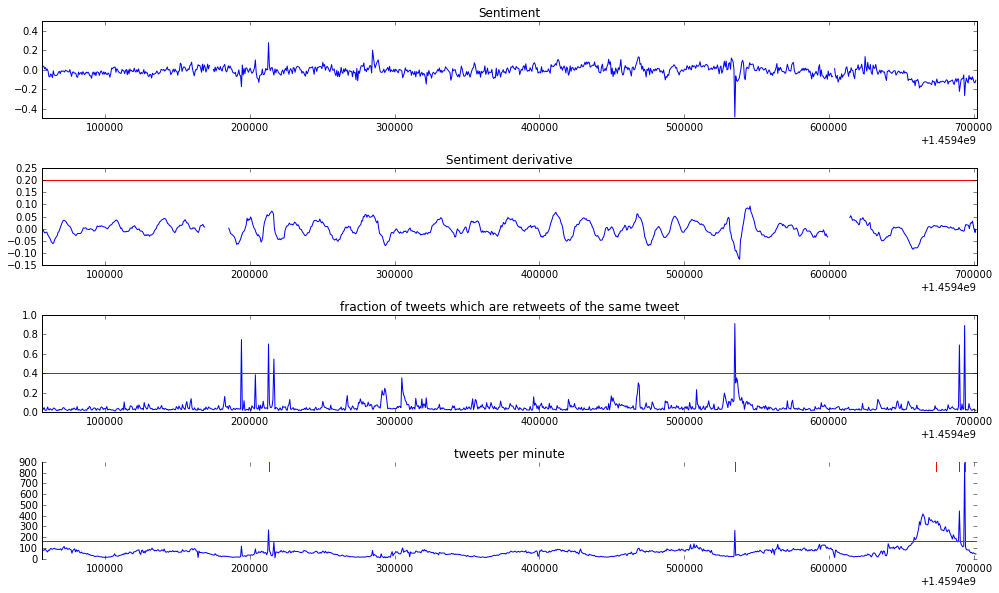

In [718]:
# threshold = np.nanstd(modes[:,3]) * 3
threshold = 0.4

plt.figure(figsize=(14,10))
plt.subplot(511)
plt.title('Sentiment')
plt.plot(data_downsampled[:,0], data_downsampled[:,1])
plt.ylim([-0.5, 0.5])
plt.xlim([data[0,0], data[-1,0]])
plt.subplot(512)
plt.title('Sentiment derivative')
plt.plot(der_smooth[:,0], der_smooth[:,1])
plt.axhline(y=der_smooth_threshold, c='r')
plt.xlim([data[0,0], data[-1,0]])
plt.subplot(513)
plt.title('fraction of tweets which are retweets of the same tweet')
plt.plot(modes[:,0], modes[:,3])
plt.ylim([0,1])
plt.xlim([data[0,0], data[-1,0]])
plt.axhline(y=threshold, c='r')
plt.subplot(514)
ax = plt.subplot(514)
plt.title('tweets per minute')
plt.plot(modes[:,0], tps_filtered/10)
plt.xlim([data[0,0], data[-1,0]])
plt.axhline(y=tps_threshold/10, c='r')
# plt.axhline(y=np.percentile(tps_filtered/10, 95), c='green')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in peaks:
    plt.axvline(x=np.mean(p), ymin=0.9, ymax=1, c='r')

plt.tight_layout()
plt.show()

<hr>

In [614]:
# # peaks in modes
# peaking = False
# for m in modes:
#     if not peaking:
#         if m[3] > threshold:
#             peaking = True
#             for y in m:
#                 print ('%f' % y).rstrip('0').rstrip('.')
#             print 'https://twitter.com/statuses/'+str(('%f' % m[1]).rstrip('0').rstrip('.'))
#             print
#     elif peaking:
#         if m[3] < threshold:
#             peaking = False

<hr>

In [615]:
# # sentiment derivative peak detection
# peaks = []
# peaking = False
# start = None
# threshold = der_smooth_threshold
# for x in der_smooth:
#     if not peaking:
#         if x[1] > threshold:
#             start = x[0]
#             peaking = True
#     elif peaking:
#         if x[1] < threshold:
#             end = x[0]
#             peaks.append([start, end])
#             start = None
#             peaking = False
# peaks = np.array(peaks)

In [719]:
len(peaks)

5

<hr>

In [720]:
i = 0
for p in peaks:
    print i
    b = np.array([d for d in data if not d[1] == 0 and d[0] > p[0] - 60*5 and d[0] < p[1] + 60*5])
    x = Counter(b[:,1]).most_common()[:5]
    for y in x:
        print y
    c = np.array([y for y in b if y[1] == x[0][0]])
    common_tweets = Counter(c[:,2]).most_common()[:5]
    for x in common_tweets:
        print x
        print 'https://twitter.com/statuses/'+str(('%f' % x[0]).rstrip('0').rstrip('.'))
    print
    i += 1

0
(0.44040000000000001, 1921)
(0.31819999999999998, 159)
(-0.58589999999999998, 85)
(0.73509999999999998, 73)
(0.20230000000000001, 52)
(7.1629404503987405e+17, 1878)
https://twitter.com/statuses/716294045039874048
(7.1628659055805645e+17, 10)
https://twitter.com/statuses/716286590558056448
(7.1629816178699059e+17, 6)
https://twitter.com/statuses/716298161786990592
(7.1625694636664832e+17, 4)
https://twitter.com/statuses/716256946366648320
(7.1629380942083277e+17, 2)
https://twitter.com/statuses/716293809420832768

1
(-0.55740000000000001, 2503)
(0.55740000000000001, 63)
(0.82250000000000001, 25)
(-0.29599999999999999, 23)
(-0.24110000000000001, 14)
(7.1764525196437914e+17, 2489)
https://twitter.com/statuses/717645251964379136
(7.176390704663593e+17, 5)
https://twitter.com/statuses/717639070466359296
(7.1764723654972211e+17, 1)
https://twitter.com/statuses/717647236549722112
(7.1764710288150528e+17, 1)
https://twitter.com/statuses/717647102881505280
(7.1764740215762125e+17, 1)
https://

In [617]:
i = 0

In [ ]:
b = np.array([d for d in data if not d[1] == 0 and d[0] > p[0] - 60*5 and d[0] < p[1] + 60*5])

In [619]:
len(b)

22693

In [620]:
from collections import Counter

In [621]:
count = Counter(b[:,1])

In [622]:
x = count.most_common()[:5]
for y in x:
#     print 'https://twitter.com/statuses/'+str(('%f' % y[0]).rstrip('0').rstrip('.'))
    print y

(-0.20230000000000001, 837)
(0.0258, 669)
(-0.2263, 533)
(0.44040000000000001, 531)
(-0.5423, 463)


In [623]:
c = np.array([y for y in b if y[1] == x[0][0]])

In [624]:
c.shape

(837, 3)

In [625]:
common_tweets = Counter(c[:,2]).most_common()[:5]
for x in common_tweets:
    print x
    print 'https://twitter.com/statuses/'+str(('%f' % x[0]).rstrip('0').rstrip('.'))

(7.1817875961925222e+17, 81)
https://twitter.com/statuses/718178759619252224
(7.1819162378031104e+17, 60)
https://twitter.com/statuses/718191623780311040
(7.1818000156524954e+17, 53)
https://twitter.com/statuses/718180001565249536
(7.181884961465344e+17, 43)
https://twitter.com/statuses/718188496146534400
(7.1817597749533901e+17, 32)
https://twitter.com/statuses/718175977495339008


<hr>

In [626]:
a = np.array([m for m in modes if m[4]/10 > 50])

In [627]:
len(a)

655

In [628]:
for x in a[-5:]:
    print ('%f' % x[1]).rstrip('0').rstrip('.')
    print 'https://twitter.com/statuses/'+str(('%f' % x[1]).rstrip('0').rstrip('.'))

718322847744192512
https://twitter.com/statuses/718322847744192512
718322847744192512
https://twitter.com/statuses/718322847744192512
718333457152286720
https://twitter.com/statuses/718333457152286720
718336058669330432
https://twitter.com/statuses/718336058669330432
718336058669330432
https://twitter.com/statuses/718336058669330432
